In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

0.008940051405967693
ACC_BIAS=0.008940051405967693
ACC_DEVIATION=0.008410298410405153
BARO_DEVIATION=0.4023614409565012


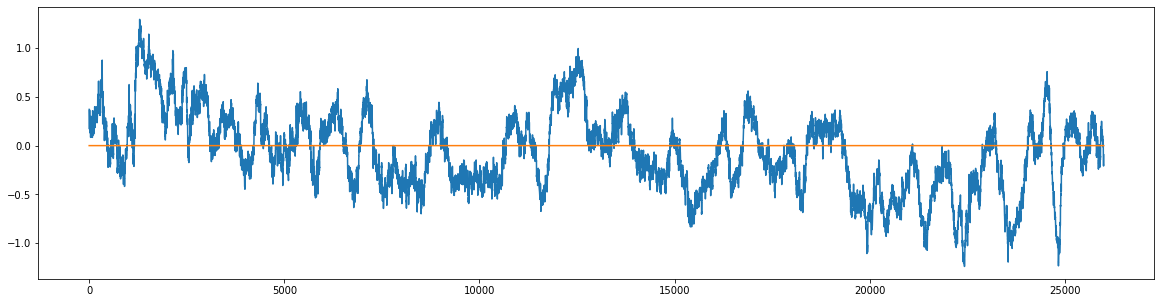

In [2]:
data = pd.read_csv("height_static.csv", delimiter=";")

print(data['sensors.accelerometer.vertical'].mean())

ACC_DEVIATION = data['sensors.accelerometer.vertical'].std()
ACC_BIAS = data['sensors.accelerometer.vertical'].mean()
BARO_DEVIATION = data['sensors.barometer.height'].std()

print(f'{ACC_BIAS=}')
print(f'{ACC_DEVIATION=}')
print(f'{BARO_DEVIATION=}')

fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(data['sensors.barometer.height'])
ax.plot(data['sensors.ultrasound.height'])
plt.show()


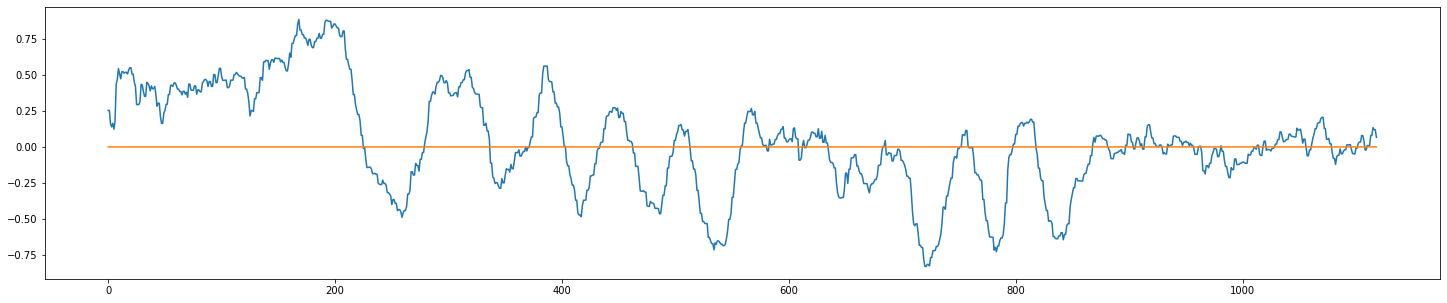

In [3]:
data = pd.read_csv("height_dynamic.csv", delimiter=";")

fig, ax = plt.subplots()
fig.set_size_inches(25, 5)
ax.plot(data['sensors.barometer.height'])
ax.plot(data['sensors.ultrasound.height'])
plt.show()

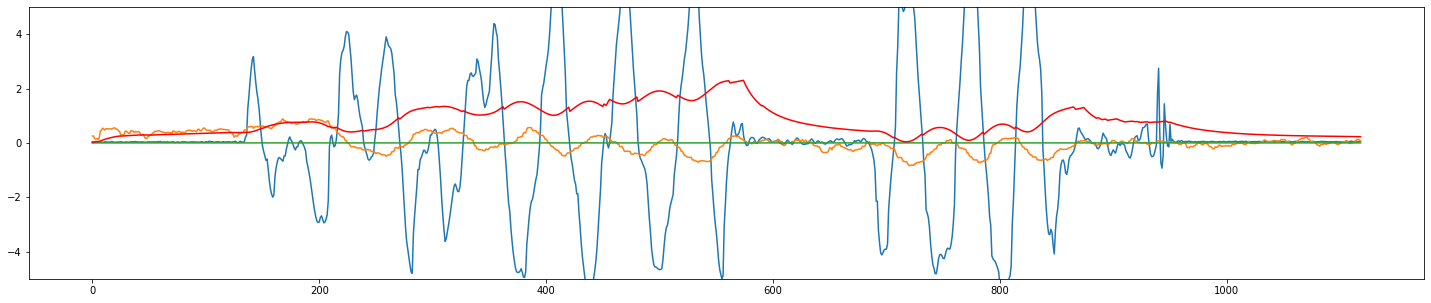

In [4]:
from filterpy.kalman import KalmanFilter

PERIOD = 0.025

COVARIANCE = 0.01

BARO_VARIANCE = BARO_DEVIATION * BARO_DEVIATION
ACC_VARIANCE  = ACC_DEVIATION * ACC_DEVIATION
ZERO_SPEED_VARIANCE = 0.0003

f = KalmanFilter(dim_x=2, dim_z=2, dim_u=1)
f.x = np.array([0., 0.])                                # Initial state
f.B = np.array([PERIOD * PERIOD / 2, PERIOD])           # Control matrix
f.F = np.array([[1., PERIOD], [0., 1.]])                # State evolution matrix
f.H = np.array([[1.,0.], [0.,1.]])                      # Observation matrix
f.P *= COVARIANCE                                       # Covariance matrix

f.R = np.array([[BARO_VARIANCE, 0], [0, ZERO_SPEED_VARIANCE]])  # Measure noise matrix
f.Q = np.array([[ACC_VARIANCE * (PERIOD ** 4) / 4,              # Process noise matrix
                 ACC_VARIANCE * (PERIOD ** 3) / 2],
                [ACC_VARIANCE * (PERIOD ** 3) / 2,
                 ACC_VARIANCE * (PERIOD ** 2)]])

z_predict = np.zeros(len(data))
speed = np.zeros(len(data))
speed_predict = np.zeros(len(data))

for i in range(len(data)):
    f.predict(u=data['sensors.accelerometer.vertical'][i])
    if abs(data['sensors.accelerometer.vertical'][i]) < 0.2:
        f.H = np.array([[1.,0.], [0.,1.]])                      # Observation matrix
    else:
        f.H = np.array([[1.,0.], [0.,0.]])                      # Observation matrix
    f.update(z=np.array([data['sensors.barometer.height'][i], 0.0]))
    z_predict[i] = f.x[0]
    speed_predict[i] = f.x[1]
    if i == 0:
        speed[i] = 0.0
    else:
        speed[i] = (data['sensors.ultrasound.height'][i] - data['sensors.ultrasound.height'][i - 1]) / PERIOD

fig, ax = plt.subplots()
fig.set_size_inches(25, 5)
ax.set_ylim([-5., 5.])
ax.plot(data['sensors.accelerometer.vertical'])
ax.plot(data['sensors.barometer.height'])
ax.plot(data['sensors.ultrasound.height'])
ax.plot(z_predict, 'r')
plt.show()

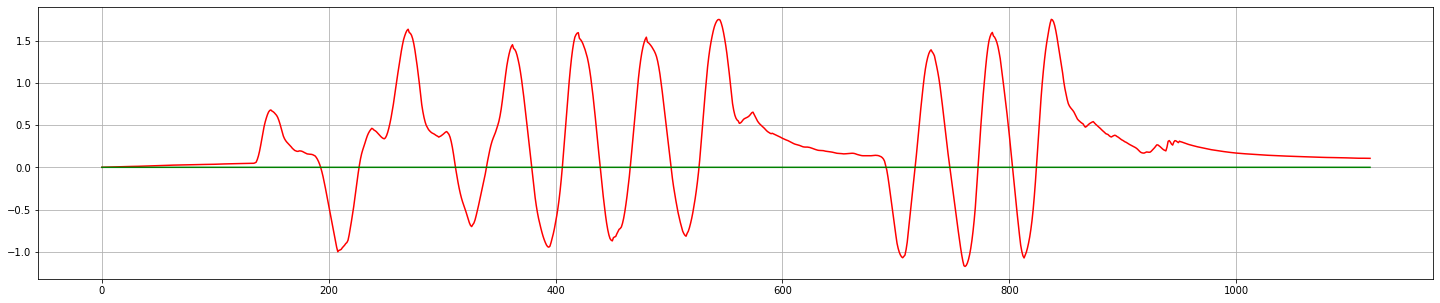

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 5)
plt.grid()
ax.plot(speed_predict, 'r')
ax.plot(speed, 'g')
plt.show()